In [65]:
import ray

import torch

def set_seeds(seed: int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seeds()


# 数据清洗与可视化

In [66]:
import os
from torch.utils.data import Dataset
from PIL import Image

class PizzaOrNotDataset(Dataset):
    def __init__(self, root_dir: str, transform=None, device="cpu"):
        self.positive_idxs = os.listdir(os.path.join(root_dir, "pizza"))
        self.negative_idxs = os.listdir(os.path.join(root_dir, "not_pizza"))
        self.root_dir = root_dir
        self.transform = transform
        self.device = device

    def __len__(self):
        return self.n_positive + self.n_negative
    
    def __getitem__(self, idx: int):
        if idx < self.n_positive:
            img_name = os.path.join(self.root_dir, "pizza", self.positive_idxs[idx])
            label = 1
        else:
            img_name = os.path.join(self.root_dir, "not_pizza", self.negative_idxs[idx - self.n_positive])
            label = 0

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)
            
        return image.to(self.device), torch.tensor(label).to(self.device)

    @property
    def n_positive(self):
        return len(self.positive_idxs)
    @property
    def n_negative(self):
        return len(self.negative_idxs)

In [67]:
from torchvision.transforms import Compose, ToTensor, Resize

device = "cuda" if torch.cuda.is_available() else "cpu"
pizza_or_not_dataset = PizzaOrNotDataset(
    root_dir="C:/Users/11234/Desktop/MLChem/Github/Mechine-Learning-and-its-Applications-in-Chemistry/Labs/Lab3/pizza_not_pizza",
    transform=Compose([ToTensor(), Resize((128, 128))]),
    device=device
)
X_demo, y_true_demo = pizza_or_not_dataset[0]
X_demo.shape, y_true_demo

(torch.Size([3, 128, 128]), tensor(1))

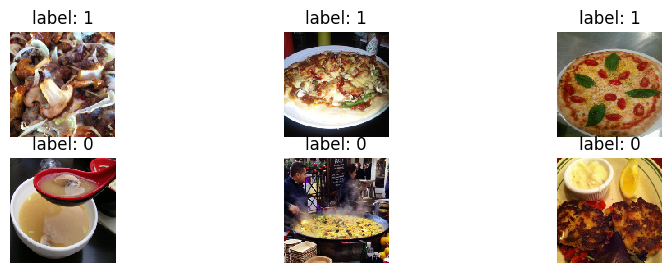

In [68]:
from typing import List
from matplotlib import pyplot as plt

def visualize_data(samples: List, n_rows: int):
    plt.figure(figsize=(10, 3))
    n_samples = len(samples)
    for i, sample in enumerate(samples):
        img, label = sample
        plt.subplot(n_rows, n_samples // n_rows, i + 1)
        plt.imshow(img.permute((1, 2, 0)).cpu(), interpolation="none")
        plt.title(f"label: {int(label.item())}")
        plt.axis("off")
    plt.show()

visualize_data(samples=[pizza_or_not_dataset[i] for i in (300, 600, 900, 1200, 1500, 1800)], n_rows=2)

# 模型的搭建

In [69]:
from torch import nn
from torch.nn import functional as F

class ConvModule(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=kernel_size, dilation=1, padding="same")
        self.pooling1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=kernel_size, dilation=3, padding="same")
        self.pooling2 = nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, X):
        X = self.pooling1(F.relu(self.conv1(X)))
        X = self.pooling2(F.relu(self.conv2(X)))
        return X

In [70]:
class PizzaOrNotModel(nn.Module):
    def __init__(self, kernel_size=3, num_hiddens=1024):
        super().__init__()
        self.conv = ConvModule(kernel_size=kernel_size)
        self.fcnn = nn.Linear(16 * 32 * 32, num_hiddens)
        self.fcnn_output = nn.Linear(num_hiddens, 1)
        self.activation = nn.Sigmoid()

    def forward(self, X):
        X = self.conv(X).reshape((X.shape[0], -1))
        X = F.relu(self.fcnn(X))
        X = self.fcnn_output(X)
        return self.activation(X).squeeze()

In [71]:
pizza_or_not_model = PizzaOrNotModel().to(device)
pizza_or_not_model(X_demo.unsqueeze(0))

tensor(0.4869, grad_fn=<SqueezeBackward0>)

# 超参数对模型训练的影响: 试验与优化

In [72]:
def train_model_epoch(model, dataloader, optimizer, criterion, log=True):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    for i, (X, y_true) in enumerate(dataloader):
        optimizer.zero_grad()
        y_prob = model(X)
        loss = criterion(y_prob.squeeze(), y_true)
        loss.backward()
        optimizer.step()
        train_loss += loss
        if log:
            if i % 100 == 0:
                print(f"Batch No. {i}, loss = {loss.item()}")
    return (train_loss / num_batches).item()

In [73]:
@torch.no_grad()
def evaluate_model(model, dataloader, criterion, threshold: float=0.5):
    model.eval()
    loss, tp, fp, tn, fn = 0, 0, 0, 0, 0
    num_batches = len(dataloader)
    for X, y_true in dataloader:
        y_prob = model(X)
        loss += criterion(y_prob, y_true)
        y_pred = (y_prob > threshold)
        for idx in range(y_true.shape[0]):
            true, pred = int(y_true[idx].item()), int(y_pred[idx].item())
            if (true, pred) == (1, 1):
                tp += 1
            elif (true, pred) == (1, 0):
                fn += 1
            elif (true, pred) == (0, 1):
                fp += 1
            else:
                tn += 1
    return (loss / num_batches).item(), tn, fp, fn, tp

## 搭建训练组件

In [74]:
from typing import Dict, List, Tuple
from torch.utils.data import DataLoader
from tqdm import tqdm

def train_model(
    train_subset, val_subset, config: Dict, num_epochs: int=5,
    device="cpu", log=True, save=False
) -> Tuple[List[float], List[float], List[float]]:
    
    model = PizzaOrNotModel(kernel_size=config["kernel_size"], num_hiddens=config["num_hiddens"]).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=0.5)

    train_loader = DataLoader(train_subset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=config["batch_size"], shuffle=False)

    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        train_loss = train_model_epoch(model, train_loader, optimizer, criterion, log)
        train_losses.append(train_loss)

        train_loss, tn, fp, fn, tp = evaluate_model(model, train_loader, criterion)
        val_loss, _, _, _, _ = evaluate_model(model, val_loader, criterion, device)

        train_accuracy = (tp + tn) / (tp + tn + fp + fn)
        val_accuracy = (tp + tn) / (tp + tn + fp + fn)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        if log:
             print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if save:
        torch.save(model.state_dict(), "model.pth")

    return train_losses, train_accuracies, val_losses, val_accuracies





In [75]:
from torch.utils.data import random_split

config = {
    "kernel_size": 3, "num_hiddens": 1024,
    "batch_size": 8, "lr": 0.01,
}
train_subset, test_subset = random_split(pizza_or_not_dataset, [0.9, 0.1])
train_losses, train_accs, val_losses, val_accs = train_model(train_subset, test_subset, config, log=True, device=device)

RuntimeError: Found dtype Long but expected Float